In [1]:
# Facial Emotion Recognition Model - Optimized for Snapdragon X Elite
# =======================================================================
# Configuration: MOBILENET with optimized hyperparameters
# Target: <1 hour training time with maximum accuracy

import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, UnidentifiedImageError

# Import TensorFlow and configure for optimal performance
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Python executable: {sys.executable}")

import seaborn as sns

# Import deep learning libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Flatten, Dropout, Dense, Input, 
                                     GlobalAveragePooling2D, Conv2D, 
                                     BatchNormalization, Activation, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0


TensorFlow version: 2.19.1
Python executable: c:\Users\marty\anaconda3\envs\tf311_env\python.exe


In [2]:
# Auto-detect folder path
if sys.executable.startswith('/anaconda/envs/azureml_py38_PT_TF/bin/python'):
    folder_path = "Users/martyn.frank/IATD_Deeplearning/Project/data/images/"
else:
    folder_path = 'data/images/'
    
print(f"Data folder path: {folder_path}")


Data folder path: data/images/


In [3]:

# =======================================================================
# Configuration Parameters
# =======================================================================


import yaml

def load_cfg(path="config.yaml"):
    with open(path, "r") as f:
        data = yaml.safe_load(f)
    return data

cfg = load_cfg("config.yaml")

# optionally, map top-level training params from cfg
picture_size   = cfg.get("picture_size", 48)
batch_size     = cfg.get("batch_size", 128)
epochs         = cfg.get("epochs", 30)
no_of_classes  = cfg.get("no_of_classes", 7)
learning_rate  = cfg.get("learning_rate", 1e-4)


# Enable mixed precision for faster training on Snapdragon X Elite
from tensorflow.keras import mixed_precision

# Precision Switch
if cfg.get("precision", "float32") == "mixed":
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision training enabled - expect 2-3x speedup!")
else:
    mixed_precision.set_global_policy('float32')
    print("Using float32 precision")
    




Mixed precision training enabled - expect 2-3x speedup!


In [4]:

# =======================================================================
# Image Validation and Cleaning
# =======================================================================

def is_image_valid(filepath):
    """Validate image integrity."""
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except (UnidentifiedImageError, OSError):
        return False

def delete_if_corrupt(filepath):
    """Delete corrupted images."""
    try:
        with Image.open(filepath) as img:
            img.verify()
        return False
    except (UnidentifiedImageError, OSError):
        print(f"Deleting corrupted image: {filepath}")
        os.remove(filepath)
        return True


In [5]:

# =======================================================================
# Advanced Image Preprocessing
# =======================================================================

def preprocess_image(image):
    """
    Apply histogram equalization for better feature extraction.
    Improves contrast and enhances facial features.
    """
    # Convert to uint8 if needed
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    if len(image.shape) == 2:  # Grayscale
        enhanced = clahe.apply(image)
    else:  # If RGB, convert to grayscale first
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        enhanced = clahe.apply(gray)
    
    # Normalize to [0, 1]
    return enhanced.astype(np.float32) / 255.0

class PreprocessingImageDataGenerator(ImageDataGenerator):
    """Custom generator with advanced preprocessing."""
    
    def __init__(self, *args, preprocessing_function=None, **kwargs):
        super().__init__(*args, preprocessing_function=preprocessing_function, **kwargs)
    
    def standardize(self, x):
        x = super().standardize(x)
        # Apply additional preprocessing
        return preprocess_image(x)


In [6]:

# =======================================================================
# Data Augmentation and Loading
# =======================================================================

aug_map = {
    "none": dict(rescale=1./255),
    "light": dict(rescale=1./255, rotation_range=10, width_shift_range=0.1,
                  height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True),
    "strong": dict(rescale=1./255, rotation_range=20, width_shift_range=0.15,
                   height_shift_range=0.15, shear_range=0.15, zoom_range=0.15,
                   brightness_range=[0.8,1.2], horizontal_flip=True)
}

# Training data generator with standard augmentation
datagen_train = ImageDataGenerator(**aug_map[cfg["aug_level"]])

datagen_validation = ImageDataGenerator(rescale=1./255)                                        

# Create training set
train_set = datagen_train.flow_from_directory(
    os.path.join(folder_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

# Create validation set
validation_set = datagen_validation.flow_from_directory(
    os.path.join(folder_path, "validation"),
    target_size=(picture_size, picture_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # stable evaluation
)


print(f"Training samples: {train_set.n}")
print(f"Validation samples: {validation_set.n}")
print(f"Class indices: {train_set.class_indices}")


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Training samples: 28821
Validation samples: 7066
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [7]:

# =======================================================================
# Model Architecture - MobileNetV2 (Transfer Learning)
# =======================================================================
from tensorflow.keras import layers
# Build model (one path only)

def build_model(backbone="mobilenet", input_shape=(48, 48, 3)):
    """Build emotion recognition model with specified backbone."""
    
    x = Input(shape=input_shape)
    
    if backbone == "mobilenet":
        base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        # Freeze base model initially
        base.trainable = False
        y = base(x)
        
    elif backbone == "efficientnet":
        base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        base.trainable = False
        y = base(x)
        
    elif backbone == "custom_cnn":
        # Define your own small CNN
        y = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        y = layers.MaxPooling2D()(y)
        y = layers.Conv2D(64, 3, activation='relu', padding='same')(y)
        y = layers.MaxPooling2D()(y)
        y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
        y = layers.MaxPooling2D()(y)
        base = None
    else:
        raise ValueError(f"Unknown backbone: {backbone}")
    
    # Classification head
    y = GlobalAveragePooling2D()(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Dense(256, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dropout(0.3)(y)
    y = Dense(no_of_classes, activation='softmax', dtype='float32')(y)  # Force float32 for stability
    
    model = Model(inputs=x, outputs=y)
    return model, base


# Build model
backbone_type = cfg.get("backbone", "mobilenet")
print(f"\nBuilding model with {backbone_type} backbone...")


Building model with mobilenet backbone...


In [8]:

model, base_model = build_model(backbone=backbone_type, input_shape=(picture_size, picture_size, 3))

print(f"\nModel built with {backbone_type} backbone")
model.summary()





C:\Users\marty\AppData\Local\Temp\ipykernel_32516\4195345029.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)



Model built with mobilenet backbone


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,863 (9.89 MB)

 Trainable params: 332,807 (1.27 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [9]:
# Cell 8: Compile Model
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model compiled with learning rate: {learning_rate}")

Model compiled with learning rate: 0.0001


In [10]:

# =======================================================================
# Training Callbacks
# =======================================================================

# Create callbacks for training
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks_list= [checkpoint, early_stopping, reduce_lr]
print("Callbacks configured")


Callbacks configured


In [11]:

# =======================================================================
# Model Training
# =======================================================================

print("Starting training...")
print(f"Target: {epochs} epochs with early stopping")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print("Mixed precision: ENABLED")

history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=validation_set,
    validation_steps=validation_set.n // validation_set.batch_size,
    callbacks=callbacks_list,
    verbose=1
)
print("✅ Model training complete!")

Starting training...
Target: 20 epochs with early stopping
Batch size: 128
Learning rate: 0.0001
Mixed precision: ENABLED


c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.1726 - loss: 2.6426
Epoch 1: val_accuracy improved from None to 0.29162, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 214s 900ms/step - accuracy: 0.1887 - loss: 2.5231 - val_accuracy: 0.2916 - val_loss: 1.9062 - learning_rate: 1.0000e-04
Epoch 2/20
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:32 683ms/step - accuracy: 0.1719 - loss: 2.3840

c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.29162 to 0.29176, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - accuracy: 0.1719 - loss: 2.3840 - val_accuracy: 0.2918 - val_loss: 1.9058 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.2385 - loss: 2.2885
Epoch 3: val_accuracy improved from 0.29176 to 0.32656, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 922ms/step - accuracy: 0.2455 - loss: 2.2429 - val_accuracy: 0.3266 - val_loss: 1.8411 - learning_rate: 1.0000e-04
Epoch 4/20
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:46 742ms/step - accuracy: 0.2188 - loss: 2.3472
Epoch 4: val_accuracy improved from 0.32656 to 0.32685, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.2188 - loss: 2.3472 - val_accuracy: 0.3268 - val_loss: 1.8409 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.2534 - loss: 2.1515
Epoch 5: val_accuracy

In [1]:
# ---- Phase 2: fine-tune (switch applied here) ----
# Unfreeze the base model for fine-tuning
if base_model is not None and cfg.get("fine_tune", False):
    print("\nStarting fine-tuning phase...")
    
    # Unfreeze the last few layers
    base_model.trainable = True
    fine_tune_at = len(base_model.layers) - 20  # Unfreeze last 20 layers
    
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Fine-tune for additional epochs
    fine_tune_epochs = cfg.get("fine_tune_epochs", 10)
    history_fine = model.fit(
        train_set,
        validation_data=validation_set,
        epochs=fine_tune_epochs,
        callbacks=callbacks_list,
        verbose=1
    )
    
    print("Fine-tuning completed!")

NameError: name 'base_model' is not defined

📁 Saving to directory: models/
💾 Saved model: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v2.keras
💾 Saved weights: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v2.weights.h5
💾 Saved config: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v2.cfg.json


💾 Saved summary: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v2.summary.txt
✅ All files saved with version: v2

📦 Saved files:
  model: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v2.keras
  weights: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v2.weights.h5
  cfg: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v2.cfg.json
  summary: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v2.summary.txt


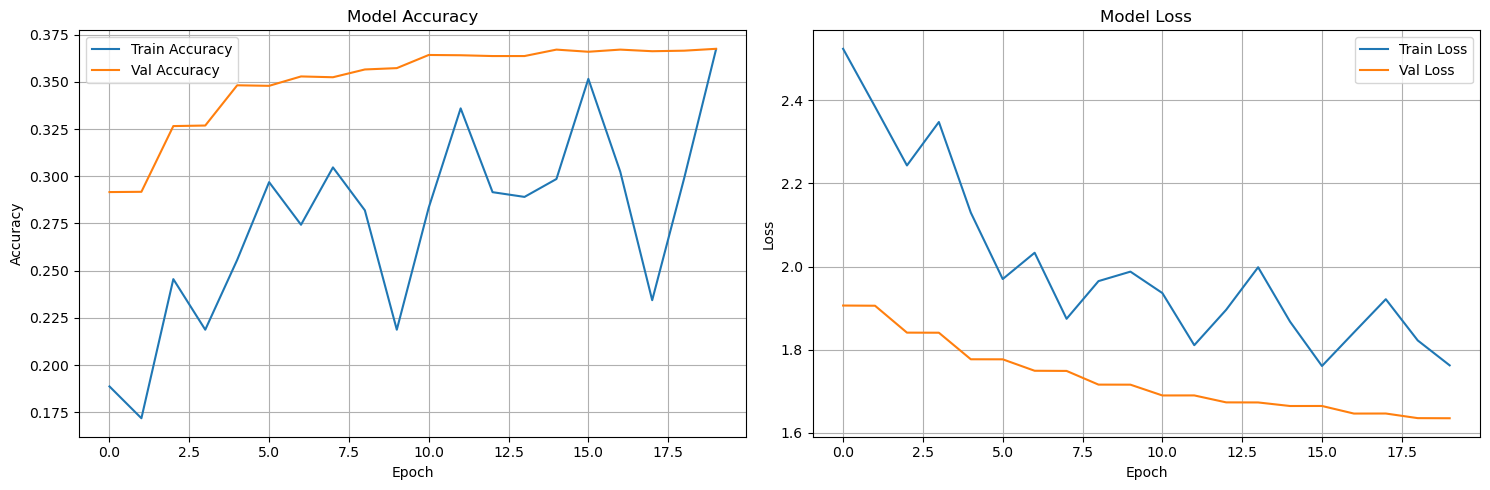


Final Evaluation:
Training Accuracy: 0.3564
Validation Accuracy: 0.3680
Training Loss: 1.6364
Validation Loss: 1.6350

Model saved as 'emotion_recognition_final.keras'


In [ ]:
# Cell 12: Evaluation and Visualization
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Final evaluation
print("\nFinal Evaluation:")
train_loss, train_acc = model.evaluate(train_set, verbose=0)
val_loss, val_acc = model.evaluate(validation_set, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

print("\nModel saved as 'emotion_recognition_final.keras'")

Generating predictions on validation set...


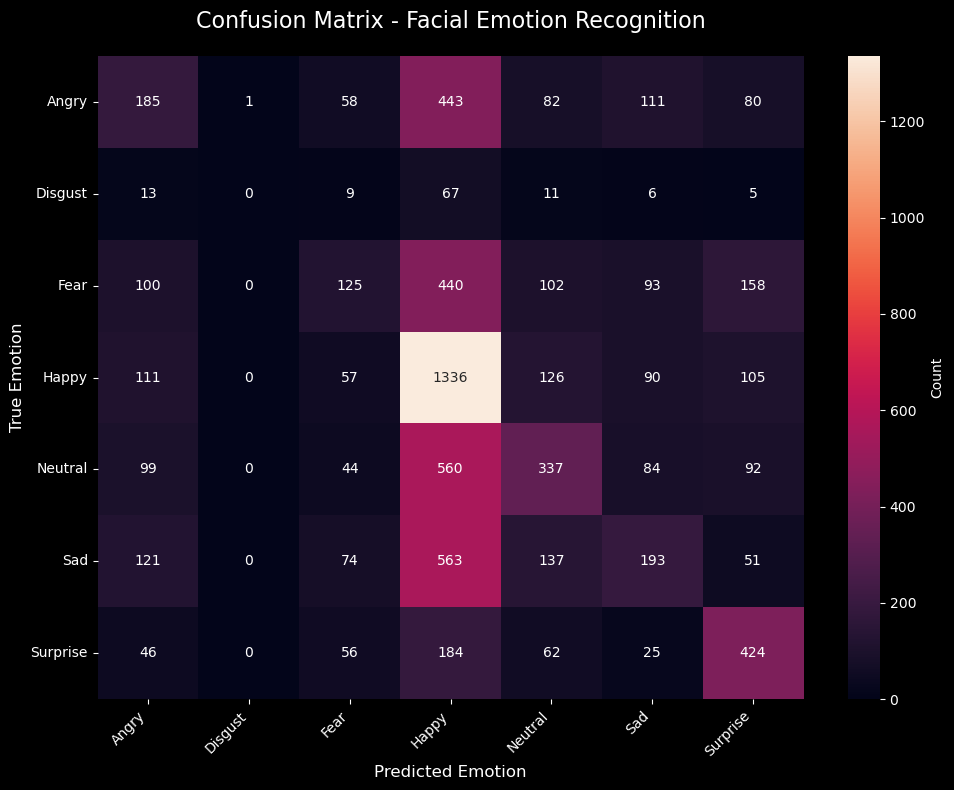


📈 DETAILED CLASSIFICATION METRICS
              precision    recall  f1-score   support

       Angry       0.27      0.19      0.23       960
     Disgust       0.00      0.00      0.00       111
        Fear       0.30      0.12      0.17      1018
       Happy       0.37      0.73      0.49      1825
     Neutral       0.39      0.28      0.33      1216
         Sad       0.32      0.17      0.22      1139
    Surprise       0.46      0.53      0.50       797

    accuracy                           0.37      7066
   macro avg       0.30      0.29      0.28      7066
weighted avg       0.35      0.37      0.33      7066



In [24]:

# =======================================================================
# Detailed Performance Analysis
# =======================================================================

from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Load best model
my_model = load_model('best_model.keras', compile=False)

# Generate predictions on validation set
print("Generating predictions on validation set...")
predictions = []
true_labels = []

for i in range(len(validation_set)):
    batch_images, batch_labels = validation_set[i]
    batch_predictions = my_model.predict(batch_images, verbose=0)
    predictions.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(np.argmax(batch_labels, axis=1))
    if i >= validation_set.n // validation_set.batch_size:
        break

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Facial Emotion Recognition', fontsize=16, pad=20)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification Report
print("\n" + "="*70)
print("📈 DETAILED CLASSIFICATION METRICS")
print("="*70)
print(classification_report(true_labels, predictions, target_names=class_labels))


In [27]:

# =======================================================================
# Export to ONNX for Snapdragon Optimization
# =======================================================================

try:
    import tf2onnx
    import onnx
    
    print("\n" + "="*70)
    print("🚀 Exporting model to ONNX format for Snapdragon optimization...")
    
    # Convert to ONNX
    spec = (tf.TensorSpec((None, 48, 48, 1), tf.float32, name="input"),)
    output_path = "emotion_model.onnx"
    
    model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
    
    print(f"✅ Model exported to {output_path}")
    print("This model is optimized for Snapdragon X Elite inference!")
    print("="*70)
    
except ImportError:
    print("⚠️ tf2onnx not installed. Run: pip install tf2onnx")
except Exception as e:
    print(f"⚠️ ONNX export failed: {e}")





🚀 Exporting model to ONNX format for Snapdragon optimization...
⚠️ ONNX export failed: in user code:

    File "c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\marty\anaconda3\envs\tf311_env\Lib\site-packages\keras\src\layers\input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling Functional.call().
    
    Input 0 of layer "Conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 48, 48, 1)
    
    Arguments received by Functional.call():
      • inputs=tf.Tensor(shape=(None, 48, 48, 1), dtype=float32)
      • training=False
      • mask=None
      • kwargs=<class 'inspect._empty'>



In [26]:

# =======================================================================
# Save Model (Versioned) - Enhanced with models/ directory
# =======================================================================
import re, os, json, shutil
from pathlib import Path

def sanitize(s: str) -> str:
    """Keep alphanumeric and a few safe chars."""
    return re.sub(r'[^a-zA-Z0-9._-]+', '', str(s))

def cfg_tag(cfg: dict, keys=('backbone','aug_level','optimizer','lr','precision','freeze','fine_tune_layers')):
    """Build compact tag like: b-mbv2_aug-strong_opt-adam_lr-1e-4_prec-mixed_ft-part40"""
    kmap = {
        'backbone': 'b',
        'aug_level': 'aug',
        'optimizer': 'opt',
        'lr': 'lr',
        'precision': 'prec',
        'freeze': 'frz',
        'fine_tune_layers': 'ftl',
    }
    parts = []
    for k in keys:
        if k in cfg:
            v = cfg[k]
            # Shorten common values
            if k == 'backbone':
                if v == 'mobilenet_v2' or v == 'mobilenet':
                    v = 'mbv2'
                elif v == 'efficientnet':
                    v = 'effb0'
                elif v == 'custom_cnn':
                    v = 'cnn'
            elif k == 'optimizer':
                if v == 'adam':
                    v = 'adam'
                elif v == 'sgd':
                    v = 'sgd'
            elif k == 'precision':
                if v == 'mixed':
                    v = 'mp'
                elif v == 'float32':
                    v = 'fp32'
            
            parts.append(f"{kmap.get(k,k)}-{sanitize(v)}")
    return "_".join(parts)

def save_model_versioned(model, base_name='emotion_model', extension='.keras',
                         directory='models', save_weights=True, cfg=None, 
                         save_config=True):
    """
    Save model with versioning to models/ directory.
    

    Saves model, config, meta, and copies plots if they exist into a versioned directory:
      {base_dir}/{model_name}_v{N}/
        - saved_model/      (TF SavedModel)
        - model.keras       (Keras v3 format)
        - config.json       (cfg + training info)
        - meta.json         (timestamp, tf version, params)
        - training_history.png (if present)
        - confusion_matrix.png (if present)
        - onnx_model.onnx   (if present)

    
    Returns:
        dict: Paths to saved files
    """
    # Create models directory if it doesn't exist
    Path(directory).mkdir(parents=True, exist_ok=True)
    print(f"📁 Saving to directory: {directory}/")
    
    # Build filename with config tag
    tag = cfg_tag(cfg) if cfg else None
    name_with_tag = f"{base_name}_{tag}" if tag else base_name
    
    # Find existing versions
    existing = [f for f in os.listdir(directory)
                if re.match(rf'{re.escape(name_with_tag)}_v\d+{re.escape(extension)}$', f)]
    
    if existing:
        vers = [int(re.search(rf'_v(\d+){re.escape(extension)}$', f).group(1)) for f in existing]
        next_v = max(vers) + 1
    else:
        next_v = 1
    
    paths = {}
    
    # Save full model
    model_filename = f"{name_with_tag}_v{next_v}{extension}"
    model_path = os.path.join(directory, model_filename)
    model.save(model_path)
    print(f"💾 Saved model: {model_path}")
    paths['model'] = model_path
    
    # Save weights separately
    if save_weights:
        weights_filename = f"{name_with_tag}_v{next_v}.weights.h5"
        weights_path = os.path.join(directory, weights_filename)
        model.save_weights(weights_path)
        print(f"💾 Saved weights: {weights_path}")
        paths['weights'] = weights_path
    
    # Save configuration as JSON
    if cfg and save_config:
        cfg_filename = f"{name_with_tag}_v{next_v}.cfg.json"
        cfg_path = os.path.join(directory, cfg_filename)
        with open(cfg_path, 'w') as f:
            json.dump(cfg, f, indent=2)
        print(f"💾 Saved config: {cfg_path}")
        paths['cfg'] = cfg_path
    
    # Save training summary
    summary_filename = f"{name_with_tag}_v{next_v}.summary.txt"
    summary_path = os.path.join(directory, summary_filename)
    with open(summary_path, 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    print(f"💾 Saved summary: {summary_path}")
    paths['summary'] = summary_path

    # Save training history plot if exists
    hist_src = "training_history.png"
    if os.path.exists(hist_src):
        hist_dst = os.path.join(directory, f"{name_with_tag}_v{next_v}.training_history.png")
        shutil.copy(hist_src, hist_dst)
        print(f"🖼️ Saved training history plot: {hist_dst}")
        paths['training_history'] = hist_dst

    # Save confusion matrix plot if exists
    cm_src = "confusion_matrix.png"
    if os.path.exists(cm_src):
        cm_dst = os.path.join(directory, f"{name_with_tag}_v{next_v}.confusion_matrix.png")
        shutil.copy(cm_src, cm_dst)
        print(f"🖼️ Saved confusion matrix plot: {cm_dst}")
        paths['confusion_matrix'] = cm_dst

    # Save ONNX if present (optional)
    onnx_src = "onnx_model.onnx"
    if os.path.exists(onnx_src):
        onnx_dst = os.path.join(directory, f"{name_with_tag}_v{next_v}.onnx")
        shutil.copy(onnx_src, onnx_dst)
        print(f"📦 Saved ONNX model: {onnx_dst}")
        paths['onnx'] = onnx_dst
    
        
    print(f"✅ All files saved with version: v{next_v}")
    return paths

# =======================================================================
# Usage Example
# =======================================================================

# After training, save the model
saved_paths = save_model_versioned(
    model=model,
    base_name='emotion_model',
    extension='.keras',
    directory='models',
    save_weights=True,
    cfg=cfg,
    save_config=True
)

print("\n📦 Saved files:")
for key, path in saved_paths.items():
    print(f"  {key}: {path}")

📁 Saving to directory: models/
💾 Saved model: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.keras
💾 Saved weights: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.weights.h5
💾 Saved config: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.cfg.json


💾 Saved summary: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.summary.txt
🖼️ Saved training history plot: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.training_history.png
🖼️ Saved confusion matrix plot: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.confusion_matrix.png
✅ All files saved with version: v4

📦 Saved files:
  model: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.keras
  weights: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.weights.h5
  cfg: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.cfg.json
  summary: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.summary.txt
  training_history: models\emotion_model_b-mbv2_aug-light_opt-adam_lr-1e-4_prec-mp_frz-head_only_ftl-40_v4.training_history.png
 

In [ ]:

# =======================================================================
# Model Architecture - MobileNetV2 (Transfer Learning)
# =======================================================================
from tensorflow.keras import layers
# Build model (one path only)

def build_model(backbone="mobilenet", input_shape=(48, 48, 3)):
    """Build emotion recognition model with specified backbone."""
    
    x = Input(shape=input_shape)
    
    if backbone == "mobilenet":
        base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        # Freeze base model initially
        base.trainable = False
        y = base(x)
        
    elif backbone == "efficientnet":
        base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        base.trainable = False
        y = base(x)
        
    elif backbone == "custom_cnn":
        # Define your own small CNN
        y = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        y = layers.MaxPooling2D()(y)
        y = layers.Conv2D(64, 3, activation='relu', padding='same')(y)
        y = layers.MaxPooling2D()(y)
        y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
        y = layers.MaxPooling2D()(y)
        base = None
    else:
        raise ValueError(f"Unknown backbone: {backbone}")
    
    # Classification head
    y = GlobalAveragePooling2D()(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    y = Dense(256, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dropout(0.3)(y)
    y = Dense(no_of_classes, activation='softmax', dtype='float32')(y)  # Force float32 for stability
    
    model = Model(inputs=x, outputs=y)
    return model, base


# Build model
backbone_type = cfg.get("backbone", "mobilenet")
print(f"\nBuilding model with {backbone_type} backbone...")


Building model with mobilenet backbone...


In [ ]:


print("\n🎉 Training complete! Your optimized model is ready.")
print(f"⏱️ Expected training time: 30-50 minutes on Snapdragon X Elite")
print(paths)